# **Protein mapping based on protein-protein interaction (PPI)**


---


**Project Overview**

This workflow analyzes a high-confidence protein-protein interaction (PPI) network to identify functionally related protein clusters through node embedding and dimensionality reduction.

**Key Steps**

1. **PPI network data acquisition** : STRING v12.0 score>=0.7 data is acquired as a PPI network data.

2. **Node Embedding with node2vec** : The node2vec algorithm is applied to the network. This process learns a low-dimensional vector representation (an "embedding") for each protein (node), capturing its topological neighborhood within the network.

3. **Dimensionality Reduction** : The resulting high-dimensional embedding data is reduced to two dimensions for visualization, using an algorithm like UMAP.

4. **Mapping and Visualization** : The 2D-embedded proteins are visualized on a scatter plot. To analyze the results, known proteins are mapped onto the plot and colored according to their Gene Ontology (GO) terms.



---

**Requirements**

In [ ]:
!pip install anndata scanpy xlsxwriter ndex2 node2vec
import ndex2
import networkx as nx
import anndata
import pandas as pd
import os
import numpy as np
from sklearn.preprocessing import StandardScaler
import umap
import matplotlib.pyplot as plt
import seaborn as sns
import json
import plotly.express as px
import plotly.graph_objects as go
from collections import Counter
from node2vec import Node2Vec



---

**Find the compornent of PPI network data**

In [ ]:
# Data check
with open('STRING_v12.0_0.7.cx', 'r') as f:
    cx_json = json.load(f)

for aspect in cx_json:
    print(list(aspect.keys()))

# Show the amount of nodes and edges
for aspect in cx_json:
    if 'nodes' in aspect:
        print(f"nodes: {len(aspect['nodes'])}")
    if 'edges' in aspect:
        print(f"edges: {len(aspect['edges'])}")

['numberVerification']
['metaData']
['nodes']
['edges']
['networkAttributes']
['nodeAttributes']
['edgeAttributes']
['cyVisualProperties']
['cartesianLayout']
['status']
nodes: 16201
edges: 236930




---


**Convert network data(.cx) to graph data**

In [ ]:
G = nx.Graph()

id_to_symbol = {}
edges = []
node_attrs = {}
edge_attrs = {}

for aspect in cx_json:
    if 'nodes' in aspect:
        for node in aspect['nodes']:
            node_id = node['@id']
            symbol = node.get('n', f"node_{node_id}")
            id_to_symbol[node_id] = symbol
    elif 'edges' in aspect:
        edges = aspect['edges']
    elif 'nodeAttributes' in aspect:
        for attr in aspect['nodeAttributes']:
            node_id = attr['po']
            name = attr['n']
            value = attr.get('v')
            if node_id not in node_attrs:
                node_attrs[node_id] = {}
            node_attrs[node_id][name] = value
    elif 'edgeAttributes' in aspect:
        for attr in aspect['edgeAttributes']:
            edge_id = attr['po']
            name = attr['n']
            value = attr.get('v')
            if edge_id not in edge_attrs:
                edge_attrs[edge_id] = {}
            edge_attrs[edge_id][name] = value

# Add nodes（set symbol as ID）
for node_id, symbol in id_to_symbol.items():
    attrs = node_attrs.get(node_id, {})
    G.add_node(symbol, **attrs)

# Add edges
for edge in edges:
    source_id = edge['s']
    target_id = edge['t']
    source_symbol = id_to_symbol.get(source_id)
    target_symbol = id_to_symbol.get(target_id)
    if source_symbol and target_symbol:
        attrs = edge_attrs.get(edge['@id'], {})
        G.add_edge(source_symbol, target_symbol, **attrs)

# Result
print(f"Loaded graph with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")

Loaded graph with 16201 nodes and 236930 edges.




---

**Nodes embedding by Node2Vec**

In [ ]:
# Node2Vec instance
node2vec = Node2Vec(G, dimensions=1024, walk_length=80, num_walks=10, p=2, q=1, workers=4)

model = node2vec.fit(window=10, min_count=1, batch_words=4, seed=42)

#print(len(model.wv))
#print(model.wv.index_to_key[:10])

# Save result
model.wv.save_word2vec_format("node_embeddings.txt")
model.save("node2vec_model.model")

# Duplicate symbols check
symbol_list = list(id_to_symbol.values())
counter = Counter(symbol_list)
duplicates = [s for s, count in counter.items() if count > 1]

print(f"Number of duplicate symbols : {len(duplicates)}")
print(f"Examples : {duplicates[:5]}")

# Create embedding dataframe
embedding_df = pd.DataFrame(
    [model.wv[node] for node in model.wv.index_to_key],
    index=model.wv.index_to_key
)

embedding_df.columns = [f"dim_{i}" for i in range(embedding_df.shape[1])]

# Save as csv
embedding_df.to_csv('STRING_0.7_gene_embeddings.csv')

Computing transition probabilities:   0%|          | 0/16201 [00:00<?, ?it/s]

Number of duplicate symbols : 0
Examples : []




---


**Directly input embedding data (skip Node2Vec process)**

For those skipping the node2vec process, please input embedding data here.

In [ ]:
#network_df = pd.read_csv('STRING_0.7_gene_embeddings.csv', index_col=0)
#print(network_df.head())



---


**Preparation of data for mapping**

In [ ]:
# Embedding data
network_df = embedding_df.copy()
#print(network_df.head())

# Protein information
protein_inf = pd.read_csv('protein.info.v12.0.csv')
#print(protein_inf.head())

# Highlighting gene
mapping_inf = pd.read_csv('Mapping_gene_list.csv')
#print(mapping_inf.head())


# Convert Ensembl IDs to preferred gene names (dataframe correction)
ensembl_rows = network_df.index[network_df.index.str.contains("ensembl:")]
print(f"Number of Ensembl ID columns : {len(ensembl_rows)}")

protein_inf = protein_inf.copy()
protein_inf["clean_id"] = protein_inf["#string_protein_id"].str.replace("9606.", "", regex=False)
#print(protein_inf.head())
id_to_name = protein_inf.set_index("clean_id")["preferred_name"].to_dict()
#print(id_to_name)

new_index = []
for idx in network_df.index:
    if "ensembl:" in idx:
        ensp_id = idx.split(":")[1]
        new_name = id_to_name.get(ensp_id, idx)
        new_index.append(new_name)
    else:
        new_index.append(idx)

network_df.index = new_index

# Check result
ensembl_rows = network_df.index[network_df.index.str.contains("ensembl:")]
print(f"Number of Ensembl ID columns (after correction) : {len(ensembl_rows)}")

Number of Ensembl ID columns : 1784
Number of Ensembl ID columns (after correction) : 0




---


**Add highlighting protein infomation to dataframe**

In [ ]:
# Create dictionary of protein information
mapping_dict = mapping_inf.to_dict('list')
#print(mapping_dict)
mapping_dict = {key: [item for item in value if pd.notna(item)] for key, value in mapping_dict.items()}
for key, value in mapping_dict.items():
    print(f"{key}: {value}")

# Add protein information column
for group, gene_list in mapping_dict.items():
    network_df[group] = network_df.index.isin(gene_list)

# Create dataframe without protein infomation column
network_numeric = network_df.iloc[:, :1024]  # Please set appropriate number of dimentions
print(network_numeric.head())

nuclear envelope: ['ROGDI', 'NPIPB3', 'NUP93', 'S100A6', 'SHISA5', 'PARP8', 'DNASE1', 'RNF180', 'RANBP1', 'GPX4', 'SREBF1', 'UBE2I', 'SUN1', 'NUP133', 'KASH5', 'PARP16', 'NUP88', 'GPER1', 'GLE1', 'NUP210', 'PAFAH1B1', 'VRK2', 'OIT3', 'LMO7', 'XPO1', 'CLGN', 'IFI27', 'PRKCZ', 'EMD', 'RAB40B', 'WDFY3', 'NDC1', 'NUP188', 'LMNA', 'RNF43', 'NUP85', 'NUP58', 'BICD2', 'UBXN4', 'SUN5', 'OSBPL6', 'SUN3', 'HAX1', 'NRM', 'RANGAP1', 'EBP', 'NEMP1', 'TREX1', 'TMEM201', 'SYNE3', 'AKAP6', 'MCM3AP', 'CLIC1', 'NUCB2', 'IST1', 'MTA1', 'GOLT1A', 'POLR2M', 'AHCTF1', 'PTGER3', 'ITSN1', 'INSR', 'TMEM170A', 'GHDC', 'SPDYA', 'SYNE4', 'DST', 'RBM15', 'FXR1', 'ATR', 'PLAAT3', 'ZFTRAF1', 'FANCL', 'RAE1', 'PARP6', 'IPO8', 'DHRS2', 'CETN3', 'PGRMC2', 'TMEM209', 'LMNB2', 'TOR4A', 'SMPD4', 'POLA1', 'CBX3', 'AAAS', 'SPAG4', 'DES', 'TYRO3', 'NUP155', 'NAPEPLD', 'AGPAT3', 'PARP11', 'RTN4', 'ZMPSTE24', 'CALR3', 'AGPAT5', 'IPO9', 'PLPP6', 'ALOX5', 'MYOF', 'MAD1L1', 'MAPK3', 'ABCF1', 'SYNE1', 'CTDNEP1', 'CUSTOS', 'MNS1', 



---


**Reducing dimensions using UMAP and mapping**

/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


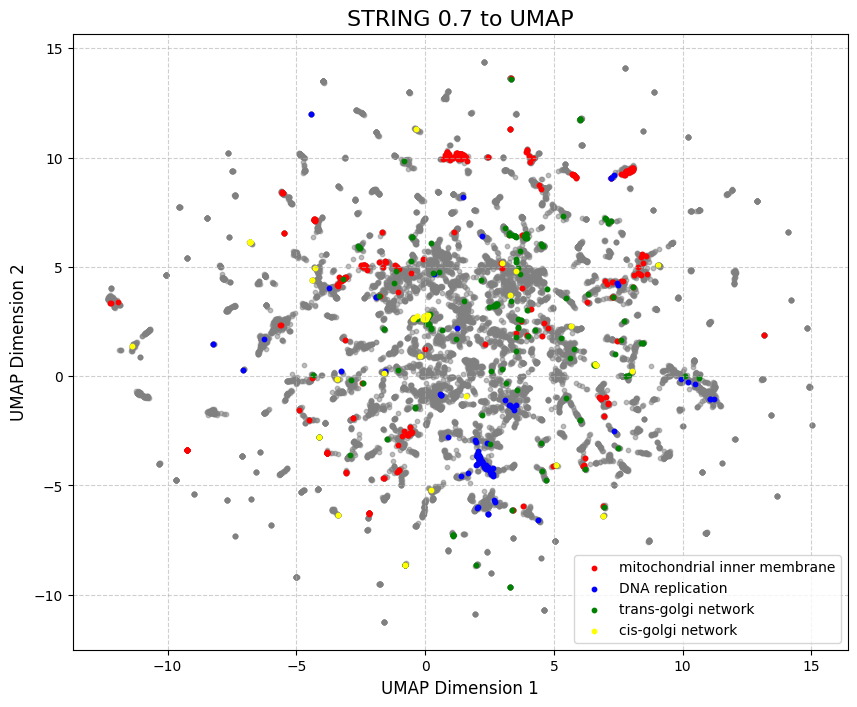

In [ ]:
# UMAP
reducer = umap.UMAP(n_components=2, random_state=42, min_dist=0.1, n_neighbors=6)
embedding = reducer.fit_transform(network_numeric)

plt.figure(figsize=(10, 8))
plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    s=10,
    alpha=0.5,
    color='gray',
)

highlight_colors = {
    'mitochondrial inner membrane': 'red',
    'DNA replication': 'blue',
    'trans-golgi network': 'green',
    'cis-golgi network': 'yellow'
}

for category, color in highlight_colors.items():
    idx = network_df[category]

    plt.scatter(
        embedding[idx, 0],
        embedding[idx, 1],
        s=10,
        alpha=1.0,
        color=color,
        label=category
    )

plt.legend()

plt.title('STRING 0.7 to UMAP', fontsize=16)
plt.xlabel('UMAP Dimension 1', fontsize=12)
plt.ylabel('UMAP Dimension 2', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()



---


**Visualization with Plotly**

In [ ]:
df_plotly = pd.DataFrame({
    'UMAP1': embedding[:, 0],
    'UMAP2': embedding[:, 1],
    'HoverName': network_df.index
},  index=network_df.index)

df_plotly['Label'] = 'Other'

# Set highlighting categories and colors
highlight_colors = {
    'mitochondrial inner membrane': 'red',
    'DNA replication': 'blue',
    'trans-golgi network': 'green',
    'cis-golgi network': 'yellow'
}

# If a gene belongs to multiple categories, it will be overwritten by the last category in the dictionary
for category in highlight_colors.keys():
    idx = network_df[category]
    df_plotly.loc[idx, 'Label'] = category

color_map = {**highlight_colors, 'Other': 'lightgray'}

fig = px.scatter(
    df_plotly,
    x='UMAP1',
    y='UMAP2',
    color='Label',
    hover_name='HoverName',
    color_discrete_map=color_map,
    opacity=0.8,
    render_mode='webgl'
)

# Graph layout
fig.update_layout(
    width=1000,
    height=800,
    title_text='STRING 0.7 to UMAP',
    legend_title_text='Category'
)

fig.update_yaxes(scaleanchor="x", scaleratio=1)

fig.show()